In [ ]:
!pip install pillow
from PIL import Image
import numpy as np
import scipy
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fft2, ifft2, fftshift, ifftshift
import cv2

In [ ]:
def Fresnel_diffraction(x,y,E,z,l):

  #field E with (x,y) coordinates with x,y in um
  #z and l is lambda also in um
  x_scale= x[-1]-x[0]
  y_scale= y[-1] - y[0]

  Nx,Ny= E.shape
  factor= 1/np.pi

  E_double= E.astype(complex)

  F_E = fftshift(fft2(fftshift(E_double)))

  Nx_1 = np.linspace(-Nx/2,Nx/2-1,Nx)
  Ny_1 = np.linspace(-Ny/2,Ny/2-1,Ny)
  k_x= np.pi* (1/(x_scale/Nx))*(Nx_1/ Nx)
  k_y= np.pi* (1/(y_scale/Ny))* (Ny_1/ Ny)
  k_x_1, k_y_1 = np.meshgrid(k_x,k_y)

  mask = np.exp(-(1j * ((l * z * factor) * (k_x_1**2 + k_y_1**2))))# Propagation mask

  F_E_D=F_E *mask

  E_D = ifftshift(ifft2(ifftshift(F_E_D)))

  return E_D


def GS_algo(E1, z1, E2, z2, tresh, steps, x, y, lam, filter): #z1, z2, x, y, lambda arre all in microns

  im1 = E1
  im2 = E2

  Nx, Ny = im1.shape

  error_treshold = tresh
  N_step = steps

  N = 0

  guess_phase = np.random.rand(Nx,Ny) # random initial phase from 0 to 1
  error_vec = [1]



  # Implement the guess phase
  im1_forced = im1*np.exp(1j*guess_phase)

  error=1
  while error >= error_treshold and N < N_step:
    N += 1

    # Propagation to z2
    im1_prop = Fresnel_diffraction(x, y, im1_forced, z2-z1 , lam)
    # Force the intensity, keep the phase
    phase_1 = np.angle(im1_prop)
    im2_forced = im2*np.exp(1j*phase_1)
    # Propagation back to z1
    im2_prop = Fresnel_diffraction(x, y, im2_forced, z1-z2, lam)
    # Force the intensity, keep the phase
    phase_2 = np.angle(im2_prop)
    im1_forced = im1*np.exp(1j*phase_2)
    if filter: # Could add a filter_type argument, but I don't see a faster convergence with any filter
      error = mean_squared_error(im1, np.absolute(im2_prop),sample_weight=im1)
    else:
      error = mean_squared_error(im1, np.absolute(im2_prop))
    error_vec.append(error)


  if N==N_step:
    print("No convergence")

  else:
    print("The algorithm converged")

  return im1_prop, im2_prop, error_vec # Corresponding to im2 guessed and im1 guessed (in this order)


def GS_algo3(E1, z1, E2, z2, E3, z3, tresh, steps, x, y, lam, filter):

  im1 = E1
  im2 = E2
  im3 = E3

  Nx, Ny = im1.shape

  error_treshold = tresh
  N_step = steps

  N = 0

  guess_phase = np.random.rand(Nx,Ny) # random initial phase from 0 to 1
  error_vec = [1]



  # Implement the guess phase
  im1_forced = im1*np.exp(1j*guess_phase)

  error=1
  while error >= error_treshold and N < N_step:
    N += 1

    # Propagation to z2
    im1_prop = Fresnel_diffraction(x, y, im1_forced, z2-z1 , lam)
    # Force the intensity, keep the phase
    phase_1 = np.angle(im1_prop)
    im2_forced = im2*np.exp(1j*phase_1)
    # Propagation to z3
    im2_prop = Fresnel_diffraction(x, y, im2_forced, z3-z2, lam)
    # Force the intensity, keep the phase
    phase_2 = np.angle(im2_prop)
    im3_forced = im3*np.exp(1j*phase_2)
    # Propagation back to z1
    im3_prop = Fresnel_diffraction(x, y, im3_forced, z1-z3 , lam)
    # Force the intensity, keep the phase
    phase_3 = np.angle(im3_prop)
    im1_forced = im1*np.exp(1j*phase_3)

    if filter: # Could add a filter_type argument, but I don't see a faster convergence with any filter
      error = mean_squared_error(im1, np.absolute(im3_prop),sample_weight=im1)
    else:
      error = mean_squared_error(im1, np.absolute(im3_prop))
    error_vec.append(error)


  if N==N_step:
    print("No convergence")

  else:
    print("The algorithm converged")

  return im1_prop, im2_prop, im3_prop, error_vec # Corresponding to im2 guessed, im3 guessed and im1 guessed (in this order)


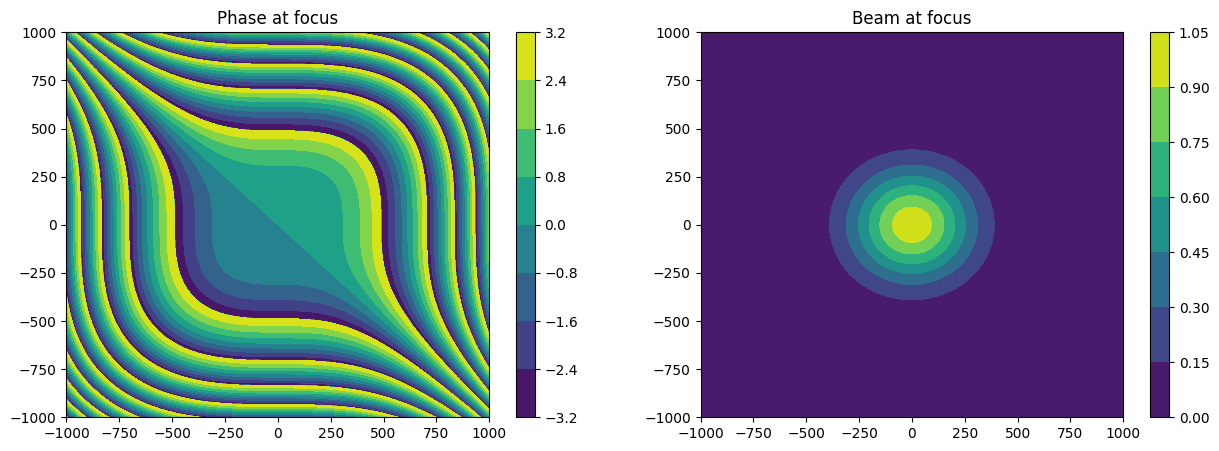

In [ ]:
def gaus2d(x, y, mx=0, my=0, sx=1, sy=1):
    return np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

x = np.linspace(-1000, 1000,1000)
y = np.linspace(-1000, 1000,1000)
xx, yy = np.meshgrid(x, y) # get 2D variables instead of 1D
E_dum = gaus2d(xx, yy,0,0,200,200)

phase = (0.003*xx)**3+(0.003*yy)**3 # Weird phase

E_comp = E_dum*np.exp(1j*phase)

E_prop_after = Fresnel_diffraction(x,y,E_comp,30000,0.8)
E_prop_before = Fresnel_diffraction(x,y,E_comp,-30000,0.8)


fig, [ax1, ax2] = plt.subplots(1,2, figsize=(15,5))
a = ax1.contourf(x,y,np.angle(E_comp))
ax1.set_title("Phase at focus")
b = ax2.contourf(x,y,np.absolute(E_comp))
ax2.set_title("Beam at focus")
plt.colorbar(a, ax=ax1)
plt.colorbar(b, ax=ax2)



No convergence
The algorithm converged


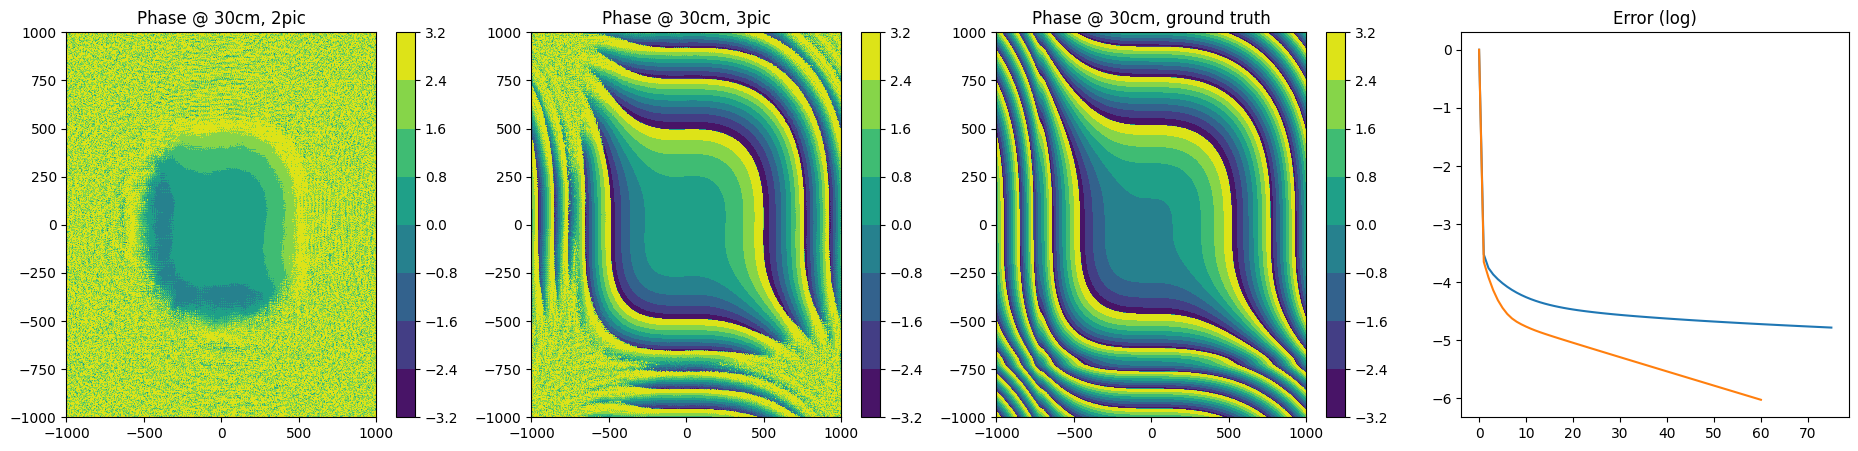

In [ ]:
E1 = np.absolute(E_comp)
E2 = np.absolute(E_prop_after)
E3 = np.absolute(E_prop_before)

# As said before here the field names are shifted

A1, A2, error_vec = GS_algo(E1, 0, E2, 30000, 1e-6, 75, x, y, 0.8, filter=False)
A1_3, A2_3, A3_3, error_vec3 = GS_algo3(E1, 0, E2, 30000, E3, -30000, 1e-6, 75, x, y, 0.8, filter=False)

fig, ax = plt.subplots(1,4, figsize=(23,4))

a = ax[0].contourf(x,y,np.angle(A1),vmin=-3.14, vmax=3.14)
ax[0].set_title("Phase @ 30cm, 2pic")

b = ax[1].contourf(x,y,np.angle(A1_3),vmin=-3.14, vmax=3.14)
ax[1].set_title("Phase @ 30cm, 3pic")

c = ax[2].contourf(x,y,np.angle(E_prop_after),vmin=-3.14, vmax=3.14)
ax[2].set_title("Phase @ 30cm, ground truth")

plt.colorbar(a, ax=ax[0])
plt.colorbar(b, ax=ax[1])
plt.colorbar(c, ax=ax[2])

ax[3].plot(np.log10(error_vec), label='2pic')
ax[3].plot(np.log10(error_vec3), label='3pic')
ax[3].set_title("Error (log)")



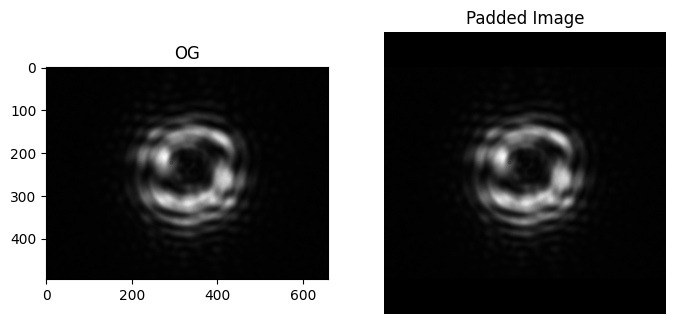

In [ ]:
def process_image(image_path, sigma_filter): #giving squared images roughly centered
    IM = Image.open(image_path)
    IM = np.array(IM)
    Nx, Ny = IM.shape

    maxSize = max(Nx, Ny)
    padX = (maxSize - Nx) // 2
    padY = (maxSize - Ny) // 2

    IM = cv2.GaussianBlur(IM.astype(np.float64), (0, 0), sigma_filter)
    padded = np.pad(IM, ((padX, padX+1), (padY, padY)), mode='constant', constant_values=0)
    padded = padded/np.max(padded)
    return padded

image_path = '/content/after_focus.tiff'
image1 = process_image(image_path, 0.1)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path), cmap='gray')  # Load and show the original image
plt.title('OG')

plt.subplot(1, 2, 2)
plt.imshow(image1, cmap='gray')
plt.title('Padded Image')
plt.axis('off')

plt.show()

(659, 659) (659, 659) (659, 659)


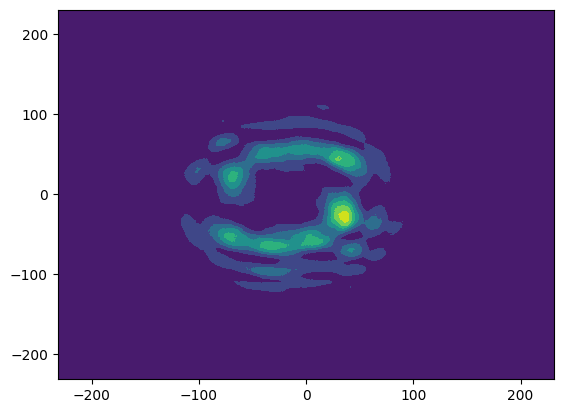

In [ ]:
E1 = np.absolute(process_image('/content/focus_non_saturated.tiff',0.01))
E2 = np.absolute(process_image('/content/after_focus.tiff',0.01))
E3 = np.absolute(process_image('/content/before_focus.tiff',0.01))

conv_factor = 200/285 # microns/pix

Nx, Ny = E1.shape
x_vec = np.linspace(-Nx//2, Nx//2, Nx)*conv_factor
y_vec = np.linspace(-Ny//2, Ny//2, Ny)*conv_factor

print(E1.shape, E2.shape, E3.shape)
plt.contourf(x_vec, y_vec, E3)


No convergence
No convergence


'\nc = ax[2].contourf(x,y,np.angle(E_prop_after),vmin=-3.14, vmax=3.14)\nax[2].set_title("Phase @ 30cm, ground truth")\nplt.colorbar(c, ax=ax[2])\n'

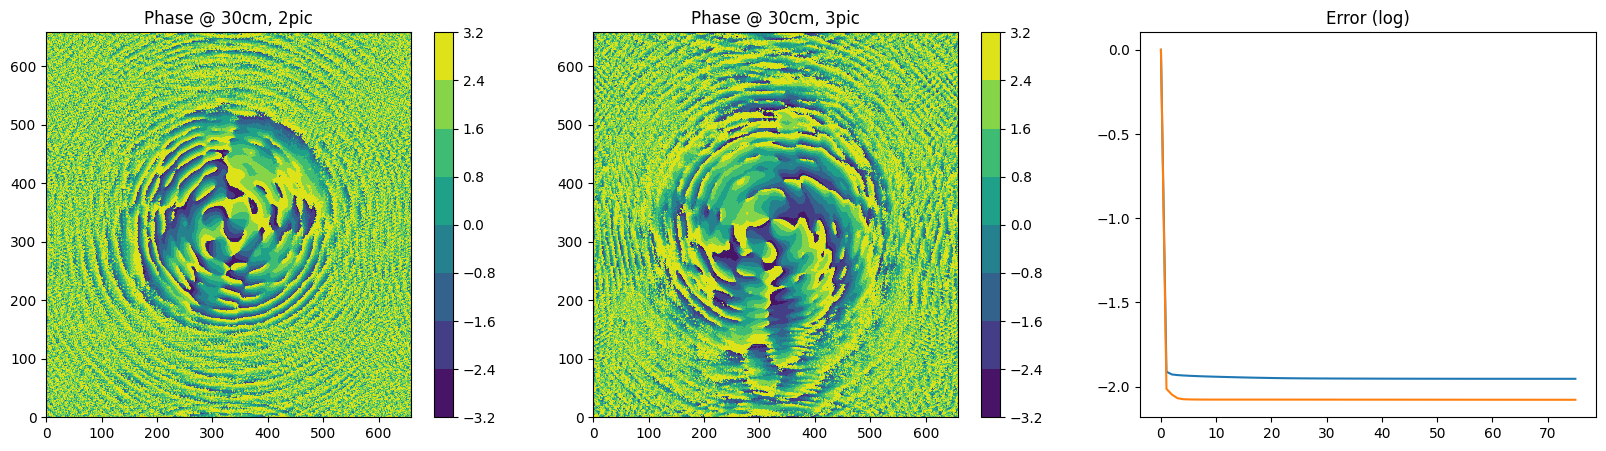

In [ ]:
A1, A2, error_vec = GS_algo(E1, 0, E2, 4100, 1e-6, 75, x_vec, y_vec, 0.515, filter=False)
A1_3, A2_3, A3_3, error_vec3 = GS_algo3(E1, 0, E2, 4100, E3, -4940, 1e-6, 75, x_vec, y_vec, 0.515, filter=False)

fig, ax = plt.subplots(1,3, figsize=(20,5))
a = ax[0].contourf(np.angle(A2),vmin=-3.14, vmax=3.14)
ax[0].set_title("Phase @ 30cm, 2pic")
b = ax[1].contourf(np.angle(A3_3),vmin=-3.14, vmax=3.14)
ax[1].set_title("Phase @ 30cm, 3pic")
plt.colorbar(a, ax=ax[0])
plt.colorbar(b, ax=ax[1])
ax[2].plot(np.log10(error_vec), label='2pic')
ax[2].plot(np.log10(error_vec3), label='3pic')
ax[2].set_title("Error (log)")

# I don't see the 2-drop thing, maybe because my error is computed using MSE
# Also I didn't plot the singularity point phases that should be linear, I don't really have the knowledge to do that

